# Evaluating the Pynta program

This notebook was developed for testing the time limitations of the Pynta program. The design of Pynta allows it to run without a GUI, therefore this notebook can also be used as a reference for performing experiments. 

Data will be simulated data, through the module called SimBrownian. 
**Important**: Data is very clean, no background, no noise.

In [1]:
import os
from multiprocessing import Queue, Process, Event
from threading import Thread
from time import sleep
import numpy as np
from pynta import BASE_DIR
from pynta.model.experiment.nano_cet.win_nanocet import NanoCET
from pynta.model.cameras.simulate_brownian import SimBrownian
from pynta.model.experiment.subscriber import subscribe

## Parameters that can change in the evaluation

The main parameter to change in this notebook is the number of particles in an image, since this is most likely the one that is going to affect the most the final outcome for the tracking algorithm. 

It is important to note that other parameters such as particle diameter (in pixels) also has a big role in total execution time.

In [262]:
frames_to_accumulate = 0  # How many frames SimBrownian will accumulate
num_particles = 50  # Number of particles in a given image
pcle_diameter = 5  # In pixels
magnification = 30 # Magnification of the microscope for the simulation of the brownian motion

**Before running the cell below**, it is important to check whether the experiment has finalized correctly. If it hasn't, ZMQ will complain about the port being in use, but this warning will appear on the console, not on the notebook.

In [263]:
SimBrownian.num_particles = num_particles
SimBrownian.frames_to_accumulate = frames_to_accumulate
SimBrownian.magnification = magnification
config_file = os.path.join(BASE_DIR, 'util', 'example_config.yml')
exp = NanoCET(config_file)
exp.initialize_camera()
exp.config['tracking']['locate']['diameter'] = pcle_diameter

## Start free run and tracking
We will start both tracking and the free run of the camera. SimBrownian has the possibility of accumulating frames into memory in order to loop through them instead of keep simulating data. If this parameter is set to a value other than 0, then you have to be careful with the fact that statistics will make no sense.

In [264]:
exp.start_tracking()
exp.start_free_run()

# Consume location timing information
In order to check the time it takes to perform a localization, we have developed the function below, which will be listening for a specific topic. 

This is a great example on how to extend the functionality of Pynta without altering the code base. In this case, we listent on a socket and push the data to a Queue. We perform this work-around in order to get the data out of the multi-processing realm, but you are free to follow different paths.

In order to stop the thread, you will need to do:
```
event.set()
```

And you will be able to check whether it worked by:
```
p.is_alive()
```

In [265]:
loc_queue = Queue()
event = Event()

def consume_location(queue, event):
    socket = subscribe(5555, 'locations_time')
    sleep(1)
    while not event.is_set():
        topic = socket.recv_string()
        data = socket.recv_pyobj()
        queue.put(data)
    socket.close()
p = Thread(target=consume_location, args=[loc_queue, event])
p.start()

## Finishing
Once you have finished with the measurements, you can stop the experiment and the ``consume_locations`` thread. It is not mandatory to do it at this time, you can first inspect the data and decide whether you would like to generate more or not. 

In [269]:
# sleep(30)
exp.stop_tracking()
exp.stop_free_run()
exp.finalize()
event.set()

## Analyzing the temporal data

We will need to get the data from a queue into a usable format. We are accumulating information on the time it took to perfom a location and the number of particles on each frame. We can read the queue and then transform the data to a numpy array. First, let's create an empty list, be sure not to overwrite it, or you will loose the information stored in it.

In [266]:
temp_data = []

In [270]:
while not loc_queue.empty():
    temp_data.append(loc_queue.get())
print('Temp Data length: ', len(temp_data))
t_data = np.array(temp_data)
print('Average time: ', np.mean(t_data[:,0]))
print('Average particles: ', np.mean(t_data[:,1]))

Temp Data length:  2846
Average time:  0.017476198544237535
Average particles:  49.32431482782853


## Plot the data

If we want to look at the data, we can make a plot, for example of the number of particles detected and the time it took, or a histogram of times.

In [14]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Time to localize particles (ms)')

Generating a frame takes longer than exposure time
Generating a frame takes longer than exposure time
Generating a frame takes longer than exposure time
Generating a frame takes longer than exposure time
Generating a frame takes longer than exposure time
Generating a frame takes longer than exposure time


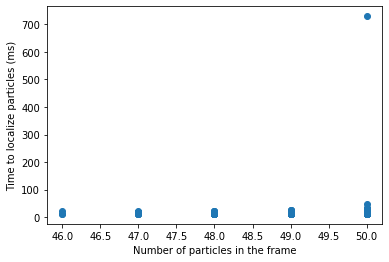

In [221]:
plt.plot(t_data[:,1], 1000*t_data[:,0], 'o')
plt.xlabel('Number of particles in the frame')
plt.ylabel('Time to localize particles (ms)')

Generating a frame takes longer than exposure time
Generating a frame takes longer than exposure time
Generating a frame takes longer than exposure time
Generating a frame takes longer than exposure time
Generating a frame takes longer than exposure time
Generating a frame takes longer than exposure time
Generating a frame takes longer than exposure time
Generating a frame takes longer than exposure time


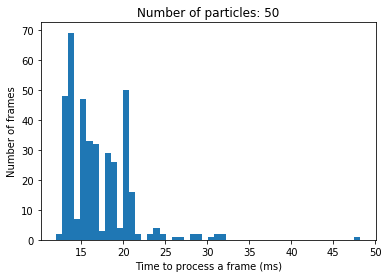

In [222]:
plt.hist(1000*t_data[t_data[:,0]<.4,0], bins=50)
plt.xlabel('Time to process a frame (ms)')
plt.ylabel('Number of frames')
plt.title(f'Number of particles: {num_particles}')
plt.savefig(f'hist_{num_particles}.png')

In [271]:
np.savetxt(f'{num_particles}-{pcle_diameter}-1920x1080_particles.dat', t_data)

# Analyze all the generated data

## First, let's see the correlation with the number of particles on each frame

Error bars are defined as the standard deviation of the distribution of times.

In [279]:
pcles = [10, 30, 50, 70, 90, 110, 130]
pcle10 = np.loadtxt('10-3_particles.dat')
pcle30 = np.loadtxt('30-3_particles.dat')
pcle50 = np.loadtxt('50-3_particles.dat')
pcle70 = np.loadtxt('70-3_particles.dat')
pcle90 = np.loadtxt('90-3_particles.dat')
pcle110 = np.loadtxt('110-3_particles.dat')
pcle130 = np.loadtxt('130-3_particles.dat')

In [280]:
p10 = np.mean(pcle10[:,0])*1000
p30 = np.mean(pcle30[:,0])*1000
p50 = np.mean(pcle50[:,0])*1000
p70 = np.mean(pcle70[:,0])*1000
p90 = np.mean(pcle90[:,0])*1000
p110 = np.mean(pcle110[:,0])*1000
p130 = np.mean(pcle130[:,0])*1000
p10err = np.std(pcle10[:, 0]*1000)
p30err = np.std(pcle30[:, 0]*1000)
p50err = np.std(pcle50[:, 0]*1000)
p70err = np.std(pcle70[:, 0]*1000)
p90err = np.std(pcle90[:, 0]*1000)
p110err = np.std(pcle110[:, 0]*1000)
p130err = np.std(pcle130[:, 0]*1000)

Text(0.5, 0, 'Number of particles')

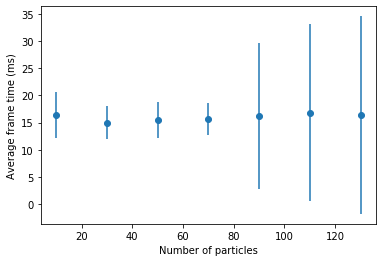

In [281]:
plt.errorbar(pcles, [p10, p30, p50, p70, p90, p110, p130], yerr=[p10err, p30err, p50err, p70err, p90err, p110err, p130err ], fmt='o')
plt.ylabel('Average frame time (ms)')
plt.xlabel('Number of particles')

## Correlation with diameter
The algorithm for identifying particles requires to determine the diameter of the particles (approximately), a-priory. This is explained in the original paper. And indeed, the bigger the particle, the slower the algorithm.

In [282]:
diameters = [3, 5, 7, 9, 11, 13]
diam3 = np.loadtxt('50-3_particles.dat')
diam5 = np.loadtxt('50-5_particles.dat')
diam7 = np.loadtxt('50-7_particles.dat')
diam9 = np.loadtxt('50-9_particles.dat')
diam11 = np.loadtxt('50-11_particles.dat')
diam13 = np.loadtxt('50-13_particles.dat')
d3 = np.mean(diam3[:,0])*1000
d5 = np.mean(diam5[:,0])*1000
d7 = np.mean(diam7[:,0])*1000
d9 = np.mean(diam9[:,0])*1000
d11 = np.mean(diam11[:,0])*1000
d13 = np.mean(diam13[:,0])*1000
d3err = np.std(diam3[:, 0]*1000)
d5err = np.std(diam5[:, 0]*1000)
d7err = np.std(diam7[:, 0]*1000)
d9err = np.std(diam9[:, 0]*1000)
d11err = np.std(diam11[:, 0]*1000)
d13err = np.std(diam13[:, 0]*1000)

Text(0.5, 0, 'Diameter of the particles (px)')

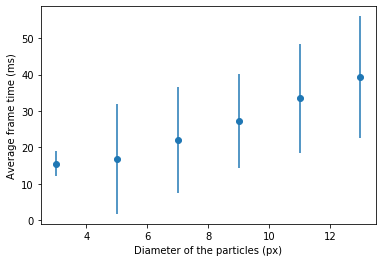

In [283]:
plt.errorbar(diameters, [d3, d5, d7, d9, d11, d13], yerr=[d3err, d5err, d7err, d9err, d11err, d13err], fmt='o')
plt.ylabel('Average frame time (ms)')
plt.xlabel('Diameter of the particles (px)')

## Dependence with frame size
Some frames were generated to see if the timing depends on the frame size. Some standard sizes (i.e. fullHD, for example) were taken in consideration

In [284]:
num_pixels = np.array([800*600, 1200*800, 1600*1200, 1920*1080])/1000000
times1 = np.loadtxt('50-5_particles.dat')
times2 = np.loadtxt('50-5-1200x800_particles.dat')
times3 = np.loadtxt('50-5-1600x1200_particles.dat')
times4 = np.loadtxt('50-5-1920x1080_particles.dat')
t1 = np.mean(times1[:,0])*1000
t2 = np.mean(times2[:,0])*1000
t3 = np.mean(times3[:,0])*1000
t4 = np.mean(times4[:,0])*1000

Text(0, 0.5, 'Frame processing time (ms)')

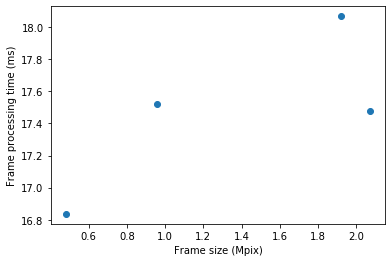

In [285]:
plt.plot(num_pixels, [t1, t2, t3, t4], 'o')
plt.xlabel('Frame size (Mpix)')
plt.ylabel('Frame processing time (ms)')